In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Subset
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset
from google.colab import drive
from matplotlib.colors import LogNorm
from os.path import join
drive.mount("/content/drive")
import os

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/classes/COMSE6998/

 Cloud_MKL_Setup.pdf
 fbg2107_jcl2259_cjr2210-HPML_final_project_proposal.pdf
 fbg2107.tar
 final_example_residual_only.png
 final_example_residual.png
 finalPlot_training_set.png
 HPML-01-Fall25.pdf
 HPML-02-Fall25.pdf
'HPML-03-Opt Algos and Pytorch-Columbia-Fall25.pdf'
 HPML-04-Pytorch-performance-Columbia-Fall2025.pdf
 HPML-05-CUDA-basics-Fall25.pdf
 HPML-06-CUDA-Advanced-Fall25.pdf
 HPML09-Quantization-Fall2025.pdf
 HPML11-KnowledgDistitllation-Columbia-Fall25.pdf
 HPML-5-CUDA-basics-Fall25.pdf
 HPML-7-DDL-Fall2025-columbia.pdf
 HPML8-pruning-Columbia-Fall2025.pdf
 HPML_Assignment4_Fall2025.pdf
 HPML_Assignments_Fall2025-1.pdf
 HPML_Assignments_Fall2025.pdf
'HPML Final Project'
 pset1
 pset2
 pset3
 pset4
 quantized_density_to_phase_grad.ipynb
 test.npz
 train.npz
 val.npz
 workergpu026_898503.1761097554771672195.pt.trace.json


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loc = "drive/MyDrive/classes/COMSE6998/"
model_loc = "drive/MyDrive/Columbia Research/Bose Einstein Condensation ML/models"

In [4]:
print(device)

cpu


In [5]:
train_data = np.load(f"{data_loc}/train.npz")
val_data = np.load(f"{data_loc}/val.npz")
test_data = np.load(f"{data_loc}/test.npz")

# Visualize Data

In [6]:
print(f"Size of train densities: {train_data['densities'].shape}")
print(f"Size of val densities: {val_data['densities'].shape}")
print(f"Size of test densities: {test_data['densities'].shape}")
print()
print(f"Size of train phase gradients: {train_data['phase_gradients'].shape}")
print(f"Size of val phase gradients: {val_data['phase_gradients'].shape}")
print(f"Size of test phase gradients: {test_data['phase_gradients'].shape}")
print()

Size of train densities: (1008, 200, 200)
Size of val densities: (336, 200, 200)
Size of test densities: (336, 200, 200)

Size of train phase gradients: (1008, 2, 200, 200)
Size of val phase gradients: (336, 2, 200, 200)
Size of test phase gradients: (336, 2, 200, 200)



In [7]:
train_data["densities"]

array([[[2.25774496e-24, 2.12975154e-24, 2.21521891e-24, ...,
         2.41283257e-24, 2.41335953e-24, 2.21571470e-24],
        [2.10565876e-24, 2.18130083e-24, 2.05235717e-24, ...,
         2.45662919e-24, 2.23297182e-24, 2.27300841e-24],
        [2.16372675e-24, 2.02724860e-24, 2.12119601e-24, ...,
         2.27960223e-24, 2.30596568e-24, 2.10937657e-24],
        ...,
        [2.51967433e-24, 2.59668972e-24, 2.43605091e-24, ...,
         2.93691998e-24, 2.66183914e-24, 2.69933448e-24],
        [2.51369292e-24, 2.35304523e-24, 2.46167814e-24, ...,
         2.65343353e-24, 2.68145078e-24, 2.45002740e-24],
        [2.26682291e-24, 2.35236576e-24, 2.20981593e-24, ...,
         2.64356781e-24, 2.40586443e-24, 2.45423892e-24]],

       [[1.88717198e-21, 1.76499490e-21, 1.90721909e-21, ...,
         1.84878728e-21, 1.95441507e-21, 1.77283179e-21],
        [1.79271712e-21, 1.87994868e-21, 1.79835235e-21, ...,
         1.94829180e-21, 1.83545260e-21, 1.88914895e-21],
        [1.89604615e-21, 

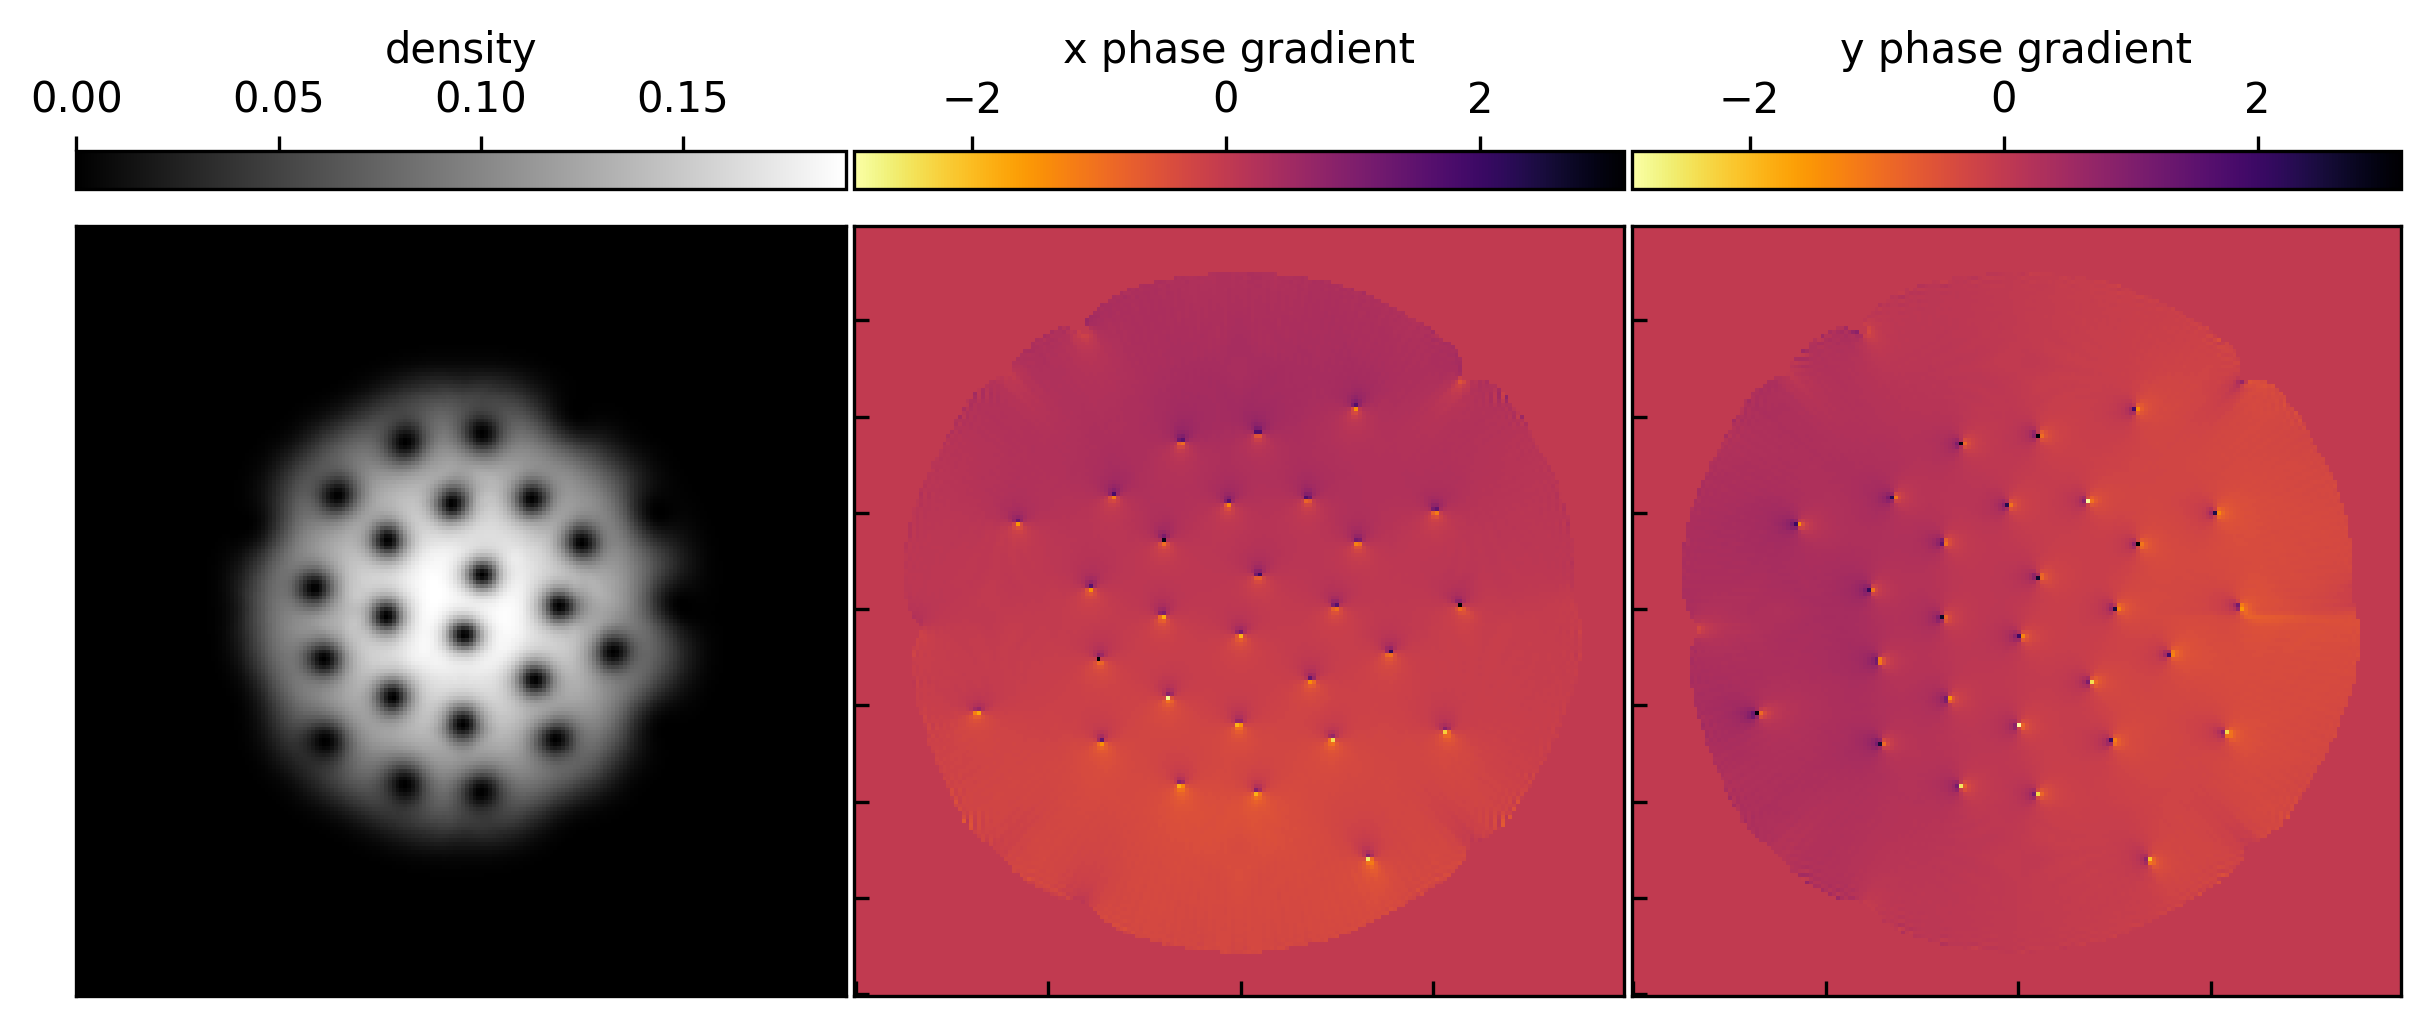

In [8]:


# Visualize an example
idx = 1
fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=300)
ax = ax.ravel()
plt.subplots_adjust(hspace=0.01, wspace=0.01)

# Calculate shared vmin and vmax for phase gradients
vmin_phase = np.min(train_data["phase_gradients"][idx, :])
vmax_phase = np.max(train_data["phase_gradients"][idx, :])

im1 = ax[0].imshow(train_data["densities"][idx], cmap="gray", origin="lower")
cbar1 = fig.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04, location="top")
cbar1.set_label("density")
im2 = ax[1].imshow(
    train_data["phase_gradients"][idx, 0],
    origin="lower",
    cmap="inferno_r",
    vmin=vmin_phase,
    vmax=vmax_phase,
)
cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04, location="top")
cbar2.set_label("x phase gradient")
im3 = ax[2].imshow(
    train_data["phase_gradients"][idx, 1],
    origin="lower",
    cmap="inferno_r",
    vmin=vmin_phase,
    vmax=vmax_phase,
)
cbar3 = fig.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04, location="top")
cbar3.set_label("y phase gradient")

# remove tick label, but preserve marks
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(direction="in")

plt.savefig(
    os.path.join(data_loc, "finalPlot_training_set.png"),
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

# Custom Datasets/Dataloaders

In [9]:
class BecDataset(Dataset):
    def __init__(self, densities, phase_grads, masks, log_eps=1e-9):
        """
        densities: (N, W, W)
        phase_grads: (N, 2, W, W)
        masks: (N, 2, W, W)
        log_eps: added before log() for numerical stability
        """
        self.densities = torch.tensor(densities).float().unsqueeze(1)
        self.phase_grads = torch.tensor(phase_grads).float()
        self.masks = torch.tensor(masks).float()
        self.log_eps = log_eps

    def __len__(self):
        return self.densities.size(0)

    def __getitem__(self, idx):
        density = self.densities[idx]
        density = torch.log(density + self.log_eps)
        phase_grad = self.phase_grads[idx]
        mask = self.masks[idx]
        return density, phase_grad, mask


train_dataset = BecDataset(
    train_data["densities"], train_data["phase_gradients"], train_data["masks"]
)
val_dataset = BecDataset(
    val_data["densities"], val_data["phase_gradients"], val_data["masks"]
)
test_dataset = BecDataset(
    test_data["densities"], test_data["phase_gradients"], test_data["masks"]
)

In [10]:
# Create corresponding dataloaders
batch_size = 8
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_dataset, num_workers=2)
test_loader = DataLoader(test_dataset, num_workers=2)

# UNET Definition

In [11]:
import torch.quantization as tq


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels, momentum=0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=0.2),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

    def fuse_model(self):
      """
      fuse Conv-BN-ReLU pairs in this DoubleConv.
      expected structure in self.double_conv:
      [Conv2d, BatchNorm2d, ReLU, Conv2d, BatchNorm2d, ReLU]
      """
      tq.fuse_modules(self.double_conv, [['0','1','2'], ['3','4','5']], inplace=True)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

    def fuse_model(self):
        # maxpool_conv = [MaxPool2d, DoubleConv]
        # fuse the DoubleConv at index 1
        self.maxpool_conv[1].fuse_model()


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, add_skip=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.add_skip = add_skip
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        if self.add_skip:
            x = torch.cat([x2, x1], dim=1)
            # print(f"dim after concatenation: {x.shape}")
        else:
            x = x1
        # print(f"Running conv2d with {self.conv.double_conv[0].in_channels} in_channels, {self.conv.double_conv[-3].out_channels} out_channels")
        return self.conv(x)

    def fuse_model(self):
        # only the DoubleConv (self.conv) is fusable; up (Upsample or ConvTranspose2d) is not.
        self.conv.fuse_model()


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """

    """
    def __init__(
        self,
        channels,
        bilinear=True,
        add_skip=True,
        out_channels=1,
        wrap_angles=False,
        verbose=False,
    ):
        super(UNet, self).__init__()
        self.channels = channels
        self.bilinear = bilinear
        self.verbose = verbose
        self.wrap_angles = wrap_angles

        self.inc = DoubleConv(channels[0], channels[1])
        if add_skip:
            # Repeat the final layer to add a skip connection in that layer
            self.downs = nn.ModuleList(
                [
                    Down(channels[i], channels[i + 1])
                    for i in range(1, len(channels) - 1)
                ]
                + [Down(channels[-1], channels[-1])]
            )
            self.ups = nn.ModuleList(
                [
                    Up(2 * channels[i + 1], channels[i], bilinear, add_skip)
                    for i in range(len(channels) - 2, 0, -1)
                ]
                + [Up(2 * channels[1], channels[1], bilinear, add_skip)]
            )
        else:
            self.downs = nn.ModuleList(
                [
                    Down(channels[i], channels[i + 1])
                    for i in range(1, len(channels) - 1)
                ]
            )
            self.ups = nn.ModuleList(
                [
                    Up(channels[i + 1], channels[i], bilinear, add_skip)
                    for i in range(len(channels) - 2, 0, -1)
                ]
            )
        self.outc = OutConv(channels[1], out_channels)

    def forward(self, x):
        x_stages = [self.inc(x)]
        if self.verbose:
            print(f"x1 shape: {x_stages[-1].shape}")

        for down in self.downs:
            x_stages.append(down(x_stages[-1]))
            if self.verbose:
                print(f"Down stage shape: {x_stages[-1].shape}")

        x = x_stages.pop()
        for up in self.ups:
            x = up(x, x_stages.pop())
            if self.verbose:
                print(f"Up stage shape: {x.shape}")

        x = self.outc(x)
        if self.verbose:
            print(f"Output shape: {x.shape}")

        # Make between -pi and pi
        if self.wrap_angles:
            x = -F.relu(x + torch.pi) + 2 * torch.pi
            x = F.relu(x) - torch.pi
        return x

    def fuse_model(self):
        """
        Call this BEFORE torch.quantization.prepare(...).
        It fuses all DoubleConv blocks in inc, downs, and ups.
        """
        # fuse initial conv block
        self.inc.fuse_model()

        # fuse each Down (their internal DoubleConv)
        for d in self.downs:
            # Down.maxpool_conv[1] is the DoubleConv
            d.fuse_model()

        # fuse each Up (their internal DoubleConv)
        for u in self.ups:
            u.fuse_model()

        # OutConv is a lone Conv2d -> nothing to fuse


In [12]:
# Example usage, showing the channel sizes
unet_8 = UNet(channels=[1, 8, 16, 32, 64, 128, 256, 512], out_channels=2, verbose=True)
dataiter = iter(train_loader)
images, labels, masks = next(dataiter)
print(images.shape)

output = unet_8(images);

torch.Size([8, 1, 200, 200])
x1 shape: torch.Size([8, 8, 200, 200])
Down stage shape: torch.Size([8, 16, 100, 100])
Down stage shape: torch.Size([8, 32, 50, 50])
Down stage shape: torch.Size([8, 64, 25, 25])
Down stage shape: torch.Size([8, 128, 12, 12])
Down stage shape: torch.Size([8, 256, 6, 6])
Down stage shape: torch.Size([8, 512, 3, 3])
Down stage shape: torch.Size([8, 512, 1, 1])
Up stage shape: torch.Size([8, 256, 3, 3])
Up stage shape: torch.Size([8, 128, 6, 6])
Up stage shape: torch.Size([8, 64, 12, 12])
Up stage shape: torch.Size([8, 32, 25, 25])
Up stage shape: torch.Size([8, 16, 50, 50])
Up stage shape: torch.Size([8, 8, 100, 100])
Up stage shape: torch.Size([8, 8, 200, 200])
Output shape: torch.Size([8, 2, 200, 200])


# Training


In [13]:
def predict(dataloader, model, device="cpu"):
    """
    Return *torch tensors* for inputs, predictions, ground_truths, masks, and errors.
    """
    model.eval()
    inputs_list = []
    predictions = []
    ground_truths = []
    masks = []
    with torch.no_grad():
        for inputs, targets, mask_batch in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            mask_batch = mask_batch.to(device)
            preds = model(inputs)

            inputs_list.append(inputs)
            predictions.append(preds)
            ground_truths.append(targets)
            masks.append(mask_batch)

    # Concatenate tensors over batch dimension
    return (
        torch.cat(inputs_list, dim=0),
        torch.cat(predictions, dim=0),
        torch.cat(ground_truths, dim=0),
        torch.cat(masks, dim=0),
    )


def train_model(train_loader, model, loss_fn, optimizer, epochs=10, device="cpu"):

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets, masks in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Run validation using torch-level predict()
        _, predictions, ground_truths, masks = predict(val_loader, model, device=device)
        val_loss = loss_fn(predictions, ground_truths, masks).item()

        print(
            f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}"
        )


def quantize_unet_post_training(model_fp32, calibration_loader, calib_batches=4, backend='fbgemm'):
    """
    Returns a static INT8 quantized model (CPU).
    """
    # Copy model
    model = UNet(channels=model_fp32.channels,
                 bilinear=model_fp32.bilinear,
                 add_skip=True,
                 out_channels=model_fp32.outc.conv.out_channels,
                 wrap_angles=model_fp32.wrap_angles,
                 verbose=False)
    model.load_state_dict(model_fp32.state_dict())
    model.eval()

    # 1. Fuse modules
    model.fuse_model()

    # 2. Set quantization config
    model.qconfig = tq.get_default_qconfig(backend)

    # 3. Prepare (insert observers)
    model_prepared = tq.prepare(model, inplace=False)

    # 4. Calibration pass (representative data)
    with torch.no_grad():
        n = 0
        for inputs, *_ in calibration_loader:
            model_prepared(inputs)
            n += 1
            if n >= calib_batches:
                break

    # 5. Convert to INT8
    model_int8 = tq.convert(model_prepared, inplace=False)

    return model_int8


In [14]:
# Custom Loss function
# Ignores losses for masked out regions (mask = 1), as these are
# Low density regions and we don't care whether we get them right or not


def mse_with_mask(outputs, targets, masks, keep_first_dim=False):
    if keep_first_dim:
        return torch.mean(((outputs - targets) ** 2) * (1 - masks), dim=(-1, -2, -3))
    else:
        return torch.mean(((outputs - targets) ** 2) * (1 - masks))


In [15]:
unet_8 = UNet(channels=[1, 8, 16, 32, 64, 128, 256, 512], out_channels=2)
optimizer = optim.Adam(unet_8.parameters(), lr=1e-3)
train_model(train_loader, unet_8, mse_with_mask, optimizer, epochs=20, device=device)

KeyboardInterrupt: 

In [ ]:

import time
import os

def benchmark_model(model, example_input, runs=50, warmup=10):
    model.eval()
    times = []
    with torch.no_grad():
        for _ in range(warmup): _ = model(example_input)
        for _ in range(runs):
            start = time.perf_counter()
            _ = model(example_input)
            end = time.perf_counter()
            times.append((end - start) * 1000)
    return {"mean_ms": sum(times)/len(times), "std_ms": (torch.tensor(times).std().item()), "runs": runs}

def model_size_mb(model):
    tmp_path = "/tmp/_tmp_model.pth"
    torch.save(model.state_dict(), tmp_path)
    return os.path.getsize(tmp_path)/(1024*1024)


# Test Set Evaluation

In [ ]:
# Get test predictions
inputs, predictions, truths, masks = predict(test_loader, unet_8, device=device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim=True)

print(f"Error on the testing set: {errors.mean()}")

In [ ]:
# ---------------------------
# FP32 vs INT8 comparison
# ---------------------------

# Example input for benchmarking
example = torch.randn(1, 1, 256, 256).to(device)  # adjust channels/size

# 1. FP32 inference
fp32_stats = benchmark_model(unet_8.to(device), example)
print("FP32:", fp32_stats)
print("FP32 size (MB):", model_size_mb(unet_8))

# 2. INT8 quantization (CPU)
unet_int8 = quantize_unet_post_training(unet_8.cpu(), train_loader, calib_batches=8)
example_cpu = example.cpu()
int8_stats = benchmark_model(unet_int8, example_cpu)
print("INT8:", int8_stats)
print("INT8 size (MB):", model_size_mb(unet_int8))

# 3. Compare outputs
with torch.no_grad():
    out_fp32 = unet_8(example)
    out_int8 = unet_int8(example_cpu).to(device)

print("L1 error:", (out_fp32 - out_int8).abs().mean().item())
print("L2 error:", torch.nn.functional.mse_loss(out_fp32, out_int8).item())
print("Max diff:", (out_fp32 - out_int8).abs().max().item())


In [ ]:
# Convert to numpy arrays
inputs = inputs.cpu().numpy()
predictions = predictions.cpu().numpy()
truths = truths.cpu().numpy()
masks = masks.cpu().numpy()
errors = errors.cpu().numpy()

/tmp/ipython-input-160985516.py:14: RuntimeWarning: invalid value encountered in divide
  residual_x = (truth_x - predicted_x)/truth_x
/tmp/ipython-input-160985516.py:15: RuntimeWarning: invalid value encountered in divide
  residual_y = (truth_y - predicted_y)/truth_y


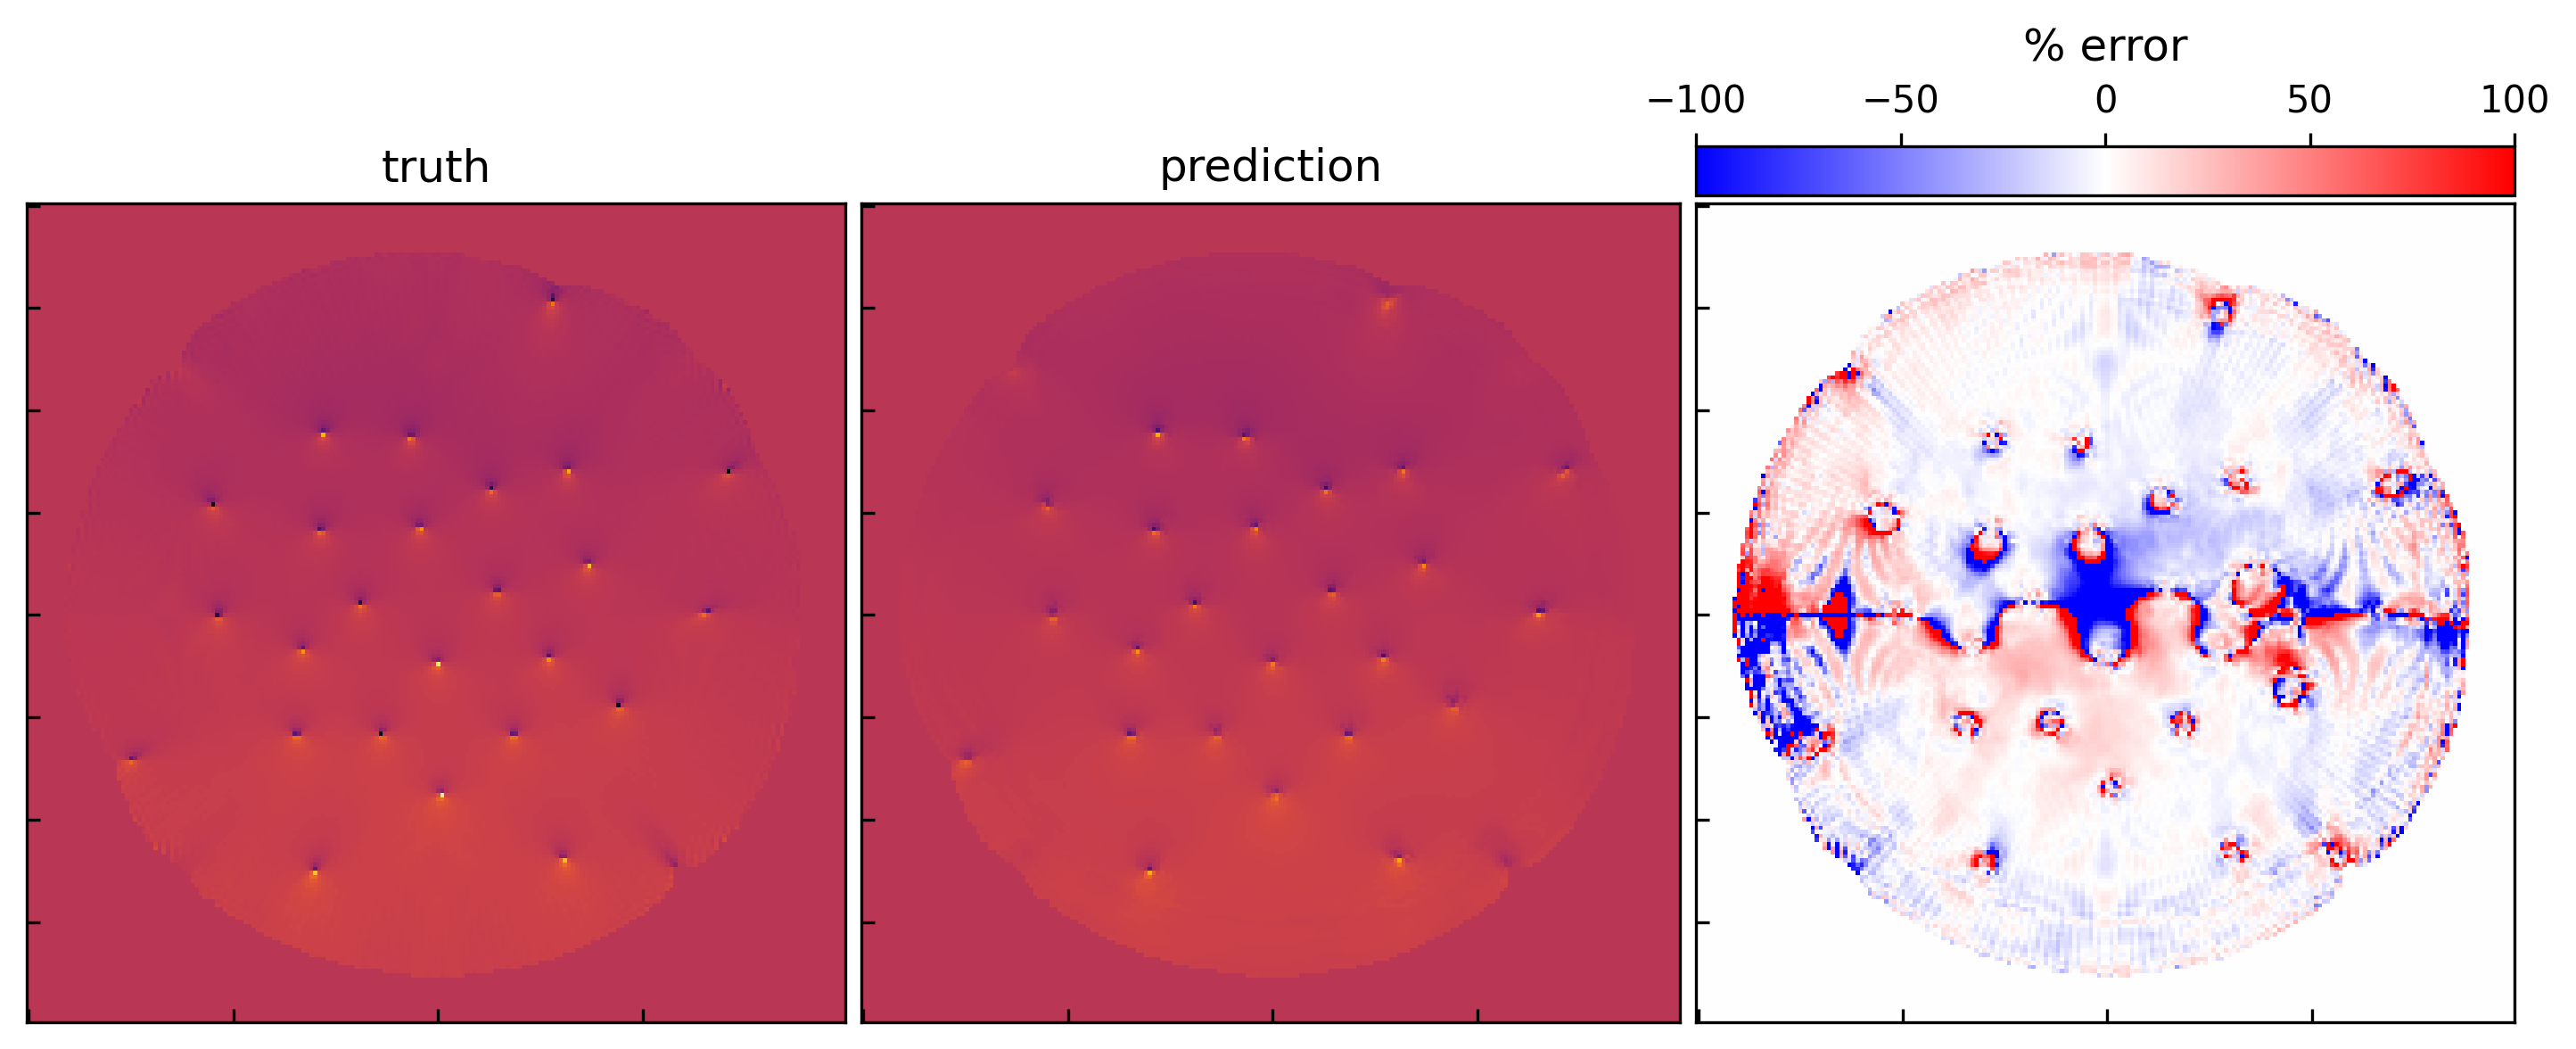

In [ ]:
# Visualize a prediction
idx = 100
vmin = truths.min()
vmax = truths.max()
fig, ax = plt.subplots(1, 3, figsize=(12, 8), dpi=300)
ax = ax.ravel()
plt.subplots_adjust(hspace=0.02, wspace=0.02)
truth_x = truths[idx, 0]
truth_y = truths[idx, 1]

predicted_x = predictions[idx, 0] * (1 - masks[idx, 0])
predicted_y = predictions[idx, 1] * (1 - masks[idx, 1])

residual_x = (truth_x - predicted_x) / truth_x
residual_y = (truth_y - predicted_y) / truth_y

# Only where truth != 0
percentage_error_x = np.zeros_like(truth_x)
mask = truth_x != 0
percentage_error_x[mask] = 100 * (truth_x[mask] - predicted_x[mask]) / truth_x[mask]

ax[0].imshow(truth_x, vmin=vmin, vmax=vmax, cmap="inferno")
ax[1].imshow(predicted_x, vmin=vmin, vmax=vmax, cmap="inferno")
# ax[3].imshow(truth_y , vmin = vmin, vmax = vmax)
# ax[4].imshow(predicted_y, vmin = vmin, vmax = vmax)

# show the residual in the 3 column
resim = ax[2].imshow(percentage_error_x, vmin=-100, vmax=100, cmap="bwr")
# ax[5].imshow(residual_y, vmin = -1, vmax = 1, cmap="bwr")
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(direction="in")

# make an inset axis for ax[2]
cbar_inset = ax[2].inset_axes([0, 1.01, 1, 0.06])

# make a colorbar using cbar_inset

cbar = fig.colorbar(resim, cax=cbar_inset, orientation="horizontal")
cbar_inset.set_title(r"% error")
# put ticks on top of the cbar
cbar_inset.xaxis.set_ticks_position("top")
# fig.colorbar(resim, ax=ax[2], location='top', label='Residual Value', fraction=0.046, pad=0.04)


ax[0].set_title("truth")
ax[1].set_title("prediction")


plt.savefig(
    os.path.join(data_loc, "final_example_residual.png"),
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

/tmp/ipython-input-3350646856.py:14: RuntimeWarning: invalid value encountered in divide
  residual_x = (truth_x - predicted_x)/truth_x
/tmp/ipython-input-3350646856.py:15: RuntimeWarning: invalid value encountered in divide
  residual_y = (truth_y - predicted_y)/truth_y


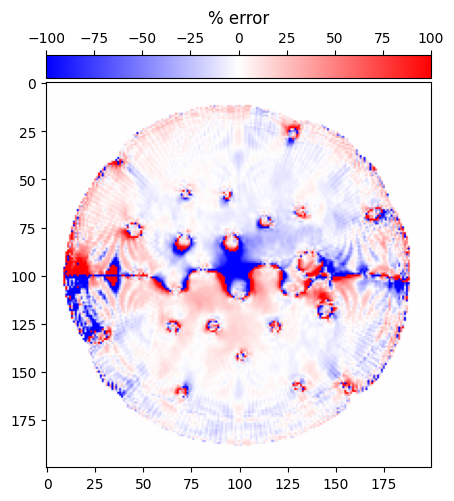

In [ ]:
# Visualize a prediction
idx = 100
vmin = truths.min()
vmax = truths.max()
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
# ax = ax.ravel()
# plt.subplots_adjust(hspace=0.02, wspace=0.02)
truth_x = truths[idx, 0]
truth_y = truths[idx, 1]

predicted_x = predictions[idx, 0] * (1 - masks[idx, 0])
predicted_y = predictions[idx, 1] * (1 - masks[idx, 1])

residual_x = (truth_x - predicted_x) / truth_x
residual_y = (truth_y - predicted_y) / truth_y

# Only where truth != 0
percentage_error_x = np.zeros_like(truth_x)
mask = truth_x != 0
percentage_error_x[mask] = 100 * (truth_x[mask] - predicted_x[mask]) / truth_x[mask]

# ax[0].imshow(truth_x , vmin = vmin, vmax = vmax, cmap="inferno")
# ax[1].imshow(predicted_x, vmin = vmin, vmax = vmax, cmap="inferno")
# ax[3].imshow(truth_y , vmin = vmin, vmax = vmax)
# ax[4].imshow(predicted_y, vmin = vmin, vmax = vmax)

# show the residual in the 3 column
resim = ax.imshow(percentage_error_x, vmin=-100, vmax=100, cmap="bwr")
# ax[5].imshow(residual_y, vmin = -1, vmax = 1, cmap="bwr")
# for a in ax:
#   a.set_xticklabels([])
#   a.set_yticklabels([])
#   a.tick_params(direction='in')

# make an inset axis for ax[2]
cbar_inset = ax.inset_axes([0, 1.01, 1, 0.06])

# make a colorbar using cbar_inset

cbar = fig.colorbar(resim, cax=cbar_inset, orientation="horizontal")
cbar_inset.set_title(r"% error")
# put ticks on top of the cbar
cbar_inset.xaxis.set_ticks_position("top")
# fig.colorbar(resim, ax=ax[2], location='top', label='Residual Value', fraction=0.046, pad=0.04)


# ax[0].set_title('truth')
# ax[1].set_title('prediction')


plt.savefig(
    os.path.join(data_loc, "final_example_residual_only.png"),
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

Text(0, 0.5, 'Frequency')

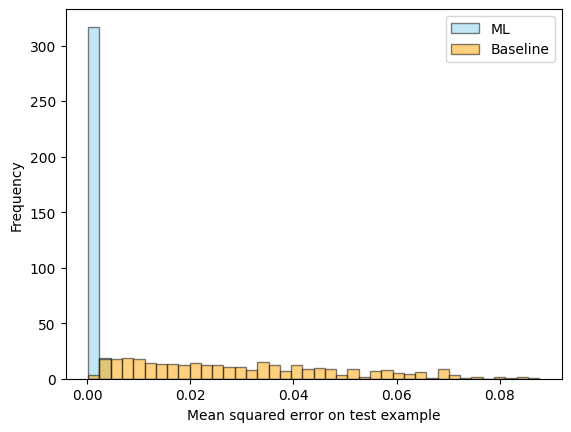

In [ ]:
# Histogram of model test set errors and baseline errors.
baseline_errors = np.var(truths, axis=(-1, -2, -3))
all_errors = np.concatenate([errors, baseline_errors])

bin_edges = np.histogram_bin_edges(all_errors, bins=40)
plt.hist(
    errors, alpha=0.5, bins=bin_edges, label="ML", color="skyblue", edgecolor="black"
)
plt.hist(
    baseline_errors,
    alpha=0.5,
    bins=bin_edges,
    label="Baseline",
    color="orange",
    edgecolor="black",
)
plt.legend()
plt.xlabel("Mean squared error on test example")
plt.ylabel("Frequency")